In [1]:
!python --version

Python 3.7.7


In [3]:
#https://stackoverflow.com/questions/53457975/pyspark-udf-function-error-in-lambda-function
import os
os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'

In [4]:
from pyspark.sql import SparkSession
# https://spark.apache.org/docs/latest/job-scheduling.html
spark = SparkSession.\
        builder.\
        appName("pyspark-notebook2-cris").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "7g").\
        config("spark.cores.max", "3").\
        config("spark.executor.instances", "1").\
        config("spark.executor.cores", "3").\
        config("spark.mongodb.input.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.mongodb.output.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
        getOrCreate()


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/spark-3.0.0-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-de0e1596-5729-4eee-acfe-7ba22d35baf4;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 260ms :: artifacts dl 9ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 from central in [default

In [5]:
spark.catalog.currentDatabase()

'default'

In [6]:
#reading dataframes from MongoDB

# sampleSize - https://stackoverflow.com/a/56255303
df = spark.read.format("mongo").option('sampleSize', 50000).load()
df.createOrReplaceTempView("mongo")


21/12/22 23:21:56 WARN MongoInferSchema: Field 'bsp' contains conflicting types converting to StringType
21/12/22 23:21:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- clk: string (nullable = true)
 |-- mc: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- marketDefinition: struct (nullable = true)
 |    |    |    |-- betDelay: integer (nullable = true)
 |    |    |    |-- bettingType: string (nullable = true)
 |    |    |    |-- bspMarket: boolean (nullable = true)
 |    |    |    |-- bspReconciled: boolean (nullable = true)
 |    |    |    |-- complete: boolean (nullable = true)
 |    |    |    |-- countryCode: string (nullable = true)
 |    |    |    |-- crossMatching: boolean (nullable = true)
 |    |    |    |-- discountAllowed: boolean (nullable = true)
 |    |    |    |-- eachWayDivisor: double (nullable = true)
 |    |    |    |-- eventId: string (nullable = true)
 |    |    |    |-- eventName: string (nullable = true)
 |    |    |    |-- eventTypeId: string (nullable = true)
 | 

In [8]:
df.show()

+--------------------+----------+--------------------+---+-------------+
|                 _id|       clk|                  mc| op|           pt|
+--------------------+----------+--------------------+---+-------------+
|[619e9dd8677066b2...|2480088678|[[1.124699287, [0...|mcm|1462537993283|
|[619e9dd8677066b2...|2480249142|[[1.124699287, [0...|mcm|1462540135101|
|[619e9dd8677066b2...|2481803835|[[1.124699287, [0...|mcm|1462555384075|
|[619e9dd8677066b2...|2481994285|[[1.124699287,, [...|mcm|1462557371191|
|[619e9dd8677066b2...|2482055516|[[1.124699287,, [...|mcm|1462557910955|
|[619e9dd8677066b2...|2482072939|[[1.124699287,, [...|mcm|1462558089056|
|[619e9dd8677066b2...|2482078964|[[1.124699287,, [...|mcm|1462558150717|
|[619e9dd8677066b2...|2482083965|[[1.124699287, [0...|mcm|1462558199155|
|[619e9dd8677066b2...|2482177634|[[1.124699287, [0...|mcm|1462559078531|
|[619e9dd8677066b2...|2480088678|[[1.124699285, [0...|mcm|1462537993283|
|[619e9dd8677066b2...|2480212422|[[1.124699285, [0.

In [9]:
#spark.sql("select * from mongo array_contains(root.mc, array('CLOSED'))").show()
from pyspark.sql.functions import explode   # Explodes lists into rows.

In [10]:
mc_exploded = df.select('*', explode(df.mc).alias('mc_row'))

In [11]:
md_only = mc_exploded.filter(mc_exploded.mc_row.marketDefinition.isNotNull())

In [237]:
md_only.show()

+--------------------+----------+--------------------+---+-------------+--------------------+
|                 _id|       clk|                  mc| op|           pt|              mc_row|
+--------------------+----------+--------------------+---+-------------+--------------------+
|[619e9dd8677066b2...|2480088678|[[1.124699287, [0...|mcm|1462537993283|[1.124699287, [0,...|
|[619e9dd8677066b2...|2480249142|[[1.124699287, [0...|mcm|1462540135101|[1.124699287, [0,...|
|[619e9dd8677066b2...|2481803835|[[1.124699287, [0...|mcm|1462555384075|[1.124699287, [0,...|
|[619e9dd8677066b2...|2482083965|[[1.124699287, [0...|mcm|1462558199155|[1.124699287, [0,...|
|[619e9dd8677066b2...|2482177634|[[1.124699287, [0...|mcm|1462559078531|[1.124699287, [0,...|
|[619e9dd8677066b2...|2480088678|[[1.124699285, [0...|mcm|1462537993283|[1.124699285, [0,...|
|[619e9dd8677066b2...|2480212422|[[1.124699285, [0...|mcm|1462539800697|[1.124699285, [0,...|
|[619e9dd8677066b2...|2480409166|[[1.124699285, [0...|mcm|14

In [12]:
# Explode the marketDefinition array.
market_definitions = md_only.selectExpr('op AS operation_type',
                                        'clk AS sequence_token',
                                        'pt AS published_time',
                                        'mc_row.id AS market_id',
                                        'mc_row.rc AS rc',
                                        'mc_row.marketDefinition.betDelay AS bet_delay',
                                        'mc_row.marketDefinition.bettingType AS betting_type',
                                        'mc_row.marketDefinition.bspMarket AS bsp_market',
                                        'mc_row.marketDefinition.bspReconciled AS bsp_reconciled',
                                        'mc_row.marketDefinition.complete AS complete',
                                        'mc_row.marketDefinition.countryCode AS country_code',
                                        'mc_row.marketDefinition.crossMatching AS cross_matching',
                                        'mc_row.marketDefinition.discountAllowed AS discount_allowed',
                                        'mc_row.marketDefinition.eventId AS event_id',
                                        'mc_row.marketDefinition.eventName AS event_name',
                                        'mc_row.marketDefinition.eventTypeId AS event_type_id',
                                        'mc_row.marketDefinition.inPlay AS in_play',
                                        'mc_row.marketDefinition.marketBaseRate AS market_base_rate',
                                        'mc_row.marketDefinition.marketTime AS market_time',
                                        'mc_row.marketDefinition.marketType AS market_type',
                                        'mc_row.marketDefinition.numberOfActiveRunners AS number_of_active_runners',
                                        'mc_row.marketDefinition.numberOfWinners AS number_of_winners',
                                        'mc_row.marketDefinition.openDate AS open_date',
                                        'mc_row.marketDefinition.persistenceEnabled AS persistence_enabled',
                                        'mc_row.marketDefinition.runnersVoidable AS runners_voidable',
                                        'mc_row.marketDefinition.settledTime AS settled_time',
                                        'mc_row.marketDefinition.status AS status',
                                        'mc_row.marketDefinition.suspendTime AS suspend_time',
                                        'mc_row.marketDefinition.timezone AS timezone',
                                        'mc_row.marketDefinition.turnInPlayEnabled AS turn_in_play_enabled',
                                        'mc_row.marketDefinition.version AS version',
                                        'mc_row.marketDefinition.name AS market_name',
                                        'mc_row.marketDefinition.regulators AS regulators',
                                        'mc_row.marketDefinition.runners AS runners')

In [13]:
market_definitions = market_definitions.filter(market_definitions["status"]=="CLOSED")

In [14]:
market_definitions = market_definitions.filter(market_definitions["market_type"]=="WIN")

In [15]:
runners_only = market_definitions.filter(market_definitions.runners.isNotNull())

In [16]:
# Explode the Runners array.
runners_exploded = runners_only.select(market_definitions.operation_type,
                                       market_definitions.published_time,
                                       market_definitions.market_id,
                                       market_definitions.market_name,
                                       market_definitions.event_id,
                                       market_definitions.event_name,
                                       explode(market_definitions.runners).alias('runner_row'))

In [17]:
runners_exploded = runners_exploded.dropDuplicates()

In [18]:
#############################
##### new dataset (just added BSP to the runners dataframe created above)
runners_exploded_wbsp = runners_only.select(market_definitions.operation_type,
                                       market_definitions.published_time,
                                       market_definitions.market_id,
                                       market_definitions.market_name,
                                       market_definitions.event_id,
                                       market_definitions.event_name,
                                       explode(market_definitions.runners).alias('runner_row'))

In [19]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp = runners_exploded_wbsp.selectExpr('operation_type',
                                      'published_time',
                                      'market_id',
                                      'market_name',
                                      'event_id',
                                      'event_name',
                                      'runner_row.id AS runner_id',
                                      'runner_row.name AS runner_name',
                                      'runner_row.status AS runner_status',
                                      'runner_row.bsp AS bsp',
                                      'runner_row.sortPriority AS runner_sort_priority')

In [20]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp = runners_wbsp.filter(runners_wbsp.runner_status!='REMOVED')
runners_wbsp = runners_wbsp.filter(runners_wbsp.runner_status!='REMOVED_VACANT')

In [21]:
##### new dataset (just added BSP to the runners dataframe created above)
#runners_wbsp.show()

In [22]:
#############################

In [23]:
# Select the useful fields, and give them user friendly names.
runners = runners_exploded.selectExpr('operation_type',
                                      'published_time',
                                      'market_id',
                                      'market_name',
                                      'event_id',
                                      'event_name',
                                      'runner_row.id AS runner_id',
                                      'runner_row.name AS runner_name',
                                      'runner_row.status AS runner_status',
                                      'runner_row.sortPriority AS runner_sort_priority')

In [24]:
# Filter down to only the records that have rc (runner changes).
rc_only = mc_exploded.filter(mc_exploded.mc_row.rc.isNotNull())

In [25]:
# Explode the rc (runner changes) array.
rc_exploded = rc_only.select(rc_only.op.alias('operation_type'),
                             rc_only.pt.alias('published_time'),
                             rc_only.mc_row.id.alias('market_id'),
                             explode(rc_only.mc_row.rc).alias('runner_change_row'))

In [26]:
# Select the useful fields, and give them user friendly names.
runner_changes = rc_exploded.selectExpr('operation_type',
                                        'published_time',
                                        'market_id',
                                        'runner_change_row.id AS runner_id',
                                        'runner_change_row.ltp AS last_traded_price')

In [27]:
#runners.show()

In [28]:
# https://www.researchgate.net/publication/351844751_Sonic_Thunder_vs_Brian_the_Snail_Are_people_affected_by_uninformative_racehorse_names
fast_names = [
    'a mile a minute', 'helter-skelter', 'quick-fire',
    'apace', 'high-speed quickly',
    'as fast as your legs would carry you',
    'hot', 'quickness',
    'as if it is going out of style', 'hotfoot', 'rapid',
    'at a rate of knots', 'hustle', 'rapid-fire',
    'at full pelt', 'in the twinkling of an eye',
    'rate',
    'at full speed', 'Jack Robinson', 'say',
    'at full tilt', 'lick', 'shot',
    'at full tilt', 'lickety-split', 'smartly',
    'before you can say Jack Robinson', 'lightning', 'souped-up',
    'blistering', 'like a shot', 'spanking',
    'breakneck' 'like a streak of lightning', 'speed',
    'brisk' 'like lightning spread', 'like wildfire',
    'chop-chop', 'meteoric', 'streak',
    'crash', 'mile', 'style',
    'express', 'nimble', 'superfast',
    'fast', 'nimbleness', 'supersonic',

    'fleet', 'nimbly', 'swift',
    'full', 'nippy', 'swiftly',
    'full steam ahead', 'pdq', 'thick',
    'gallop', 'pell-mell', 'thick and fast',
    'galloping', 'poky', 'tilt',
    'go like hot cakes', 'posthaste', 'top',
    'have a heavy foot', 'precipitous', 'twinkling',
    'headlong', 'precipitously', 'whoosh',
    'heavy', 'prompt', 'wildfire',
    'hell', 'promptly', 'zippy',
    'hell for leather', 'quick',


    'accelerated', 'high-speed', 'pell-mell',
    'at full speed', 'hurried', 'post-haste',
    'at full tilt', 'hurriedly', 'quick',
    'at speed', 'in a flash', 'quickly',
    'at the speed of light', 'in a hurry', 'rapid',
    'blistering', 'in a trice', 'rapidly',
    'breakneck', 'in a wink', 'smart',
    'brisk', 'in haste', 'speedily',
    'briskly', 'in time', 'speedy',
    'energetically', 'in no time at all', 'sporty',
    'expeditious', 'in the blink of an eye', 'sprightly',
    'expeditiously', 'like a flash', 'swift',
    'express', 'like a shot', 'swiftly',
    'fast', 'like an arrow from a bow', 'turbo',
    'fast-moving', 'lively', 'unhesitating',
    'fleet-footed', 'meteoric', 'whirlwind',
    'flying', 'nimble', 'with all haste',
    'hastily', 'on the double', 'with dispatch',
    'hasty', 'pell-mell', 'without delay',

    'acceleration', 'haste', 'scutter',
    'alacrity', 'hasten', 'sharpness',
    'blast', 'hurriedness', 'shoot',
    'bolt', 'hurry', 'spank along',
    'bowl along', 'hurry', 'speed',
    'briskness', 'hurtle', 'speediness',
    'career', 'immediacy', 'sprint',
    'celerity', 'momentum', 'stampede',
    'charge', 'pace', 'streak',
    'dart', 'precipitateness', 'sweep',
    'dash', 'promptness', 'swiftness',
    'dispatch', 'quickness', 'swoop',
    'expedition', 'race', 'tempo',
    'expeditiousness', 'rapidity', 'uzz',
    'fastness', 'rate', 'velocity',
    'flash', 'rattle along', 'whirl',
    'fly', 'run', 'whizz',
    'gallop', 'rush', 'whoosh',
    'go hell for leather', 'scramble', 'wing',
    'go like lightning', 'scud', 'zoom',
    'hare', 'scurry',

    'abrupt', 'impetuous', 'rushed',
    'agility', 'outrun', 'scramble',
    'dash', 'overhasty', 'speed',
    'disconcerted', 'overrun', 'speedily',
    'dodge', 'promptly', 'speedy',
    'haste', 'quick', 'sudden',
    'hastily', 'quickly', 'suddenly',
    'hurried', 'rapid', 'swift',
    'hurriedly', 'rapidly', 'swiftly',
    'hurry', 'rush', 'zoom',

    'accelerate', 'haste', 'race',
    'acceleration', 'hasten', 'rapidity',
    'agility', 'hie', 'rush',
    'airspeed', 'hurriedly', 'speedy',
    'celerity', 'hurry', 'stronghold',
    'dash', 'pace', 'swift',
    'decelerate', 'quick', 'swiftness',
    'expedite', 'quicken', 'tempo',
    'fast', 'quickly', 'urgently',
    'fastness', 'quickness', 'velocity',

    'Apache', 'Bentley', 'Blustery',
    'Bullet', 'Buzz', 'Comet',
    ',Cougar', ',Falcon', 'Faster',
    'Flash', 'Ghost', 'rider', 'Harley',
    'Jet', 'Jump', 'Jumping',
    'Miles', 'Mustang', 'Pony express',
    'Quick', 'Quicky', 'Racer',
    'Rapid', 'Rapide', 'Rocket',
    'Sonic', 'Speedy', 'Taz',
    'Tornado', 'Traveler', 'Wildfire',
    'Voyager', 'Wild', 'Velocity', 

    'Sonic Power', 'Speed Dragon', 'Zippy Lad', 'Lightening Vault',
    'Powerful Jet', 'Orbit Express', 'Swift Chap', 'Blazing Tempo',
    'Brave Falcon', 'Rush Now', 'Top Magic', 'Dixie Flyer',
    'Esprit De Bullet', 'Strike Fast', 'Hustle Hard', 'Diamond Rush',
    'Crown Me Fast', 'Hot Seat', 'Top Gear', 'Bright Bullet',
    'Quick Art', 'Rush Of Blood', 'Top Boy', 'Meteoric',
    'Moments',
    'One Wild Guy', 'Sonic Thunder', 'Grand Gallop', 'Zippy Speed',
    'Run for Roses', 'Saratoga',
    'Wildcat',
    'Quick Beers', 'Sudden Rush',
    'Flyingwithoutwings', 'Fast On', 'Dazzlem Quick', 'You Drive I Fly',
    'Irish Rocket', 'Hot Sauce', 'Mighty Flying', 'frost'
]

In [29]:
for i in range(len(fast_names)):
    fast_names[i] = fast_names[i].lower()

In [30]:
runners = runners.filter(runners.runner_status!='REMOVED')
runners = runners.filter(runners.runner_status!='REMOVED_VACANT')

In [31]:
#runners.show()

In [32]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType, StringType, DoubleType

In [33]:
@udf(BooleanType())
def is_fast(name):
    if name is None:
        return False
    name = name.lower()
    for s in fast_names:
        if s in name:
            return True
    return False

In [34]:
from pyspark.sql.functions import lit, col

In [35]:
runners_fast = runners.withColumn('is_fast_horse',  is_fast(runners.runner_name))

In [36]:
#############################
### aisling with bsp data
runners_fast_wbsp = runners_wbsp.withColumn('is_fast_horse',  is_fast(runners_wbsp.runner_name)) 

In [37]:
### aisling with bsp data
runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp.isNotNull())

In [38]:
runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp!='None')

In [39]:
runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp!='NaN')

In [40]:
runners_fast_wbsp.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('bsp', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [41]:
#runners_fast_wbsp.show()

In [42]:
## turning bsp to integer type
from pyspark.sql.types import IntegerType


In [43]:
runners_fast_wbsp = runners_fast_wbsp.withColumn("bsp", runners_fast_wbsp["bsp"].cast(IntegerType()))

In [44]:
runners_fast_wbsp.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('bsp', 'int'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [458]:
#runners_fast_wbsp.count()

In [459]:
#############################

In [460]:
runners_fast.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [461]:
#runners_fast.show()

In [45]:
runners_fast_only = runners_fast

In [46]:
runners_fast_only = runners_fast.filter(runners_fast.is_fast_horse=='true')

In [47]:
#runners_fast_only.show()

In [48]:
runners_fast_only_win = runners_fast_only.filter(runners_fast_only.runner_status=='WINNER')

In [49]:
#runners_fast_only_win.show()

In [50]:
###########################

In [51]:
runners_fast_wbsp=runners_fast_wbsp.na.drop()
runners_fast_wbsp=runners_fast_wbsp.filter(runners_fast_wbsp.bsp > 1)
runners_fast_wbsp_sample1000 = runners_fast_wbsp.limit(100000)
runners_fast_wbsp_sample = runners_fast_wbsp

In [52]:
#runners_fast_wbsp_sample.show(100)

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [53]:
columns_to_drop = ['operation_type', 'published_time', 'market_id', 'market_name', 'event_id', 'event_name', 'runner_id', 'runner_name', 'runner_sort_priority' ]


In [54]:
runners_fast_wbsp_sample1 = runners_fast_wbsp_sample.drop(*columns_to_drop)
runners_fast_wbsp_sample1_1000 = runners_fast_wbsp_sample1000.drop(*columns_to_drop)

In [55]:
#runners_fast_wbsp_sample1.show()

In [56]:
### Sum of two or more columns in pyspark

from pyspark.sql.functions import col

In [57]:
runners_fast_wbsp_sample2=runners_fast_wbsp_sample1.withColumn("implied_prob", 1/col("bsp"))
runners_fast_wbsp_sample2_1000=runners_fast_wbsp_sample1_1000.withColumn("implied_prob", 1/col("bsp"))

In [58]:
#runners_fast_wbsp_sample2.show(10)

In [59]:
columns_to_drop = ["bsp"]
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.drop(*columns_to_drop)
runners_fast_wbsp_sample2_1000 = runners_fast_wbsp_sample2_1000.drop(*columns_to_drop)

In [60]:
#runners_fast_wbsp_sample2.groupby("runner_status").count().show()

In [61]:
#runners_fast_wbsp_sample2.groupby("is_fast_horse").count().show()

In [62]:
#runners_fast_wbsp_sample2.show()

In [63]:
#!pip install numpy

In [64]:
from pyspark.ml.classification import LogisticRegression

In [65]:
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.withColumn("is_fast_horse_num", runners_fast_wbsp_sample2["is_fast_horse"].cast(IntegerType()))
runners_fast_wbsp_sample2_1000 = runners_fast_wbsp_sample2_1000.withColumn("is_fast_horse_num", runners_fast_wbsp_sample2_1000["is_fast_horse"].cast(IntegerType()))

In [66]:
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.drop("is_fast_horse")
runners_fast_wbsp_sample2_1000 = runners_fast_wbsp_sample2_1000.drop("is_fast_horse")

In [67]:
runners_fast_wbsp_sample2.dtypes

[('runner_status', 'string'),
 ('implied_prob', 'double'),
 ('is_fast_horse_num', 'int')]

In [68]:
#runners_fast_wbsp_sample2.show(1)

In [69]:
cols = runners_fast_wbsp_sample2.columns

In [70]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['is_fast_horse_num']
#  is_fast_horse, runner_status, implied_prob
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'runner_status', outputCol = 'label')

stages += [label_stringIdx]

numericCols = ['implied_prob']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid='skip')

stages += [assembler]

In [71]:
# pipline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(runners_fast_wbsp_sample2)
runners_fast_wbsp_sample2 = pipelineModel.transform(runners_fast_wbsp_sample2)

pipelineModel = pipeline.fit(runners_fast_wbsp_sample2_1000)
runners_fast_wbsp_sample2_1000 = pipelineModel.transform(runners_fast_wbsp_sample2_1000)

In [72]:
selectedCols = ['label', 'features'] + cols
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.select(selectedCols)
runners_fast_wbsp_sample2.printSchema()

runners_fast_wbsp_sample2_1000 = runners_fast_wbsp_sample2_1000.select(selectedCols)
runners_fast_wbsp_sample2_1000.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- runner_status: string (nullable = true)
 |-- implied_prob: double (nullable = true)
 |-- is_fast_horse_num: integer (nullable = true)

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- runner_status: string (nullable = true)
 |-- implied_prob: double (nullable = true)
 |-- is_fast_horse_num: integer (nullable = true)



In [73]:
#runners_fast_wbsp_sample2.head()
#runners_fast_wbsp_sample2_1000.head()

Row(label=0.0, features=DenseVector([1.0, 0.0769]), runner_status='LOSER', implied_prob=0.07692307692307693, is_fast_horse_num=0)

In [74]:
#!pip install pandas

In [75]:
import pandas as pd

In [76]:
runners_fast_wbsp_sample2.dtypes

[('label', 'double'),
 ('features', 'vector'),
 ('runner_status', 'string'),
 ('implied_prob', 'double'),
 ('is_fast_horse_num', 'int')]

In [77]:
#pd.DataFrame(runners_fast_wbsp_sample2.take(5), columns=runners_fast_wbsp_sample2.columns).transpose()

In [78]:
runners_fast_wbsp_sample2=runners_fast_wbsp_sample2.na.drop()
runners_fast_wbsp_sample2_1000=runners_fast_wbsp_sample2_1000.na.drop()


In [79]:
train, test = runners_fast_wbsp_sample2.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

train_1000, test_1000 = runners_fast_wbsp_sample2_1000.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train_1000.count()))
print("Test Dataset Count: " + str(test_1000.count()))

Training Dataset Count: 611618


Test Dataset Count: 261885


Training Dataset Count: 7040


Test Dataset Count: 2960


In [80]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
lrModel_1000 = lr.fit(train_1000)

21/12/23 00:11:40 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/23 00:11:40 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [81]:
import numpy as np
modelcoefficients=np.array(lrModel.coefficients)

names=[x["name"] for x in sorted(train.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
   train.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], 
   key=lambda x: x["idx"])]


matchcoefs=np.column_stack((modelcoefficients,np.array(names)))

import pandas as pd

matchcoefsdf=pd.DataFrame(matchcoefs)

matchcoefsdf.columns=['Coefvalue', 'Feature']

print(matchcoefsdf)

               Coefvalue                      Feature
0  -0.010540359015250014  is_fast_horse_numclassVec_0
1     6.3421948755621225                 implied_prob


In [82]:
import numpy as np
modelcoefficients_1000=np.array(lrModel_1000.coefficients)

names=[x["name"] for x in sorted(train.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
   train_1000.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], 
   key=lambda x: x["idx"])]


matchcoefs_1000=np.column_stack((modelcoefficients_1000,np.array(names)))

import pandas as pd

matchcoefsdf_1000=pd.DataFrame(matchcoefs_1000)

matchcoefsdf_1000.columns=['Coefvalue', 'Feature']

print(matchcoefsdf_1000)

             Coefvalue                      Feature
0  0.17820379510463386  is_fast_horse_numclassVec_0
1    6.153192367562812                 implied_prob


In [83]:
#train = 622682
predictions_train = lrModel.transform(train)

y_true = predictions_train.select(['label']).collect()
y_pred = predictions_train.select(['prediction']).collect()

predictions_train_1000 = lrModel_1000.transform(train_1000)

y_true_1000 = predictions_train_1000.select(['label']).collect()
y_pred_1000 = predictions_train_1000.select(['prediction']).collect()

In [84]:
#predictions_train.count()

611466

In [85]:
len(y_true), len(y_pred)

(611414, 612011)

In [86]:
#predictions_train.show(50)

In [87]:
from sklearn.metrics import classification_report, confusion_matrix
print()
print(classification_report(y_true, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [611414, 612011]

In [88]:
from sklearn.metrics import classification_report, confusion_matrix
print()
print(classification_report(y_true_1000, y_pred_1000))


              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      6274
         1.0       0.00      0.00      0.00       766

    accuracy                           0.89      7040
   macro avg       0.45      0.50      0.47      7040
weighted avg       0.79      0.89      0.84      7040



/opt/conda/envs/python37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [611414, 612011]

In [ ]:
import matplotlib.pyplot as plt
cm_1000 = confusion_matrix(y_true_1000, y_pred_1000)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_1000[i, j], ha='center', va='center', color='red')
plt.show()

In [90]:
#!pip install matplotlib

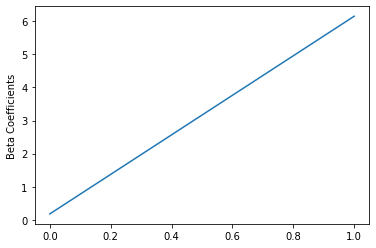

In [91]:
import matplotlib.pyplot as plt
import numpy as np
beta_1000 = np.sort(lrModel_1000.coefficients)
plt.plot(beta_1000)
plt.ylabel('Beta Coefficients')
plt.show()

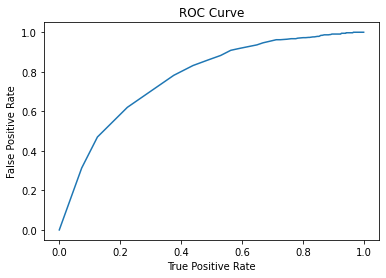

Training set areaUnderROC: 0.7724341661180332


In [92]:
trainingSummary_1000 = lrModel_1000.summary
roc_1000 = trainingSummary_1000.roc.toPandas()
plt.plot(roc_1000['FPR'],roc_1000['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set area Under ROC: ' + str(trainingSummary_1000.areaUnderROC))

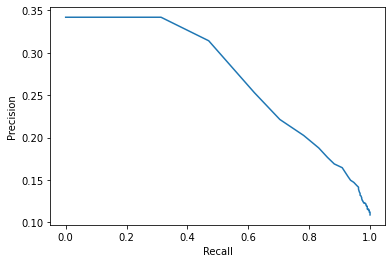

In [93]:
pr_1000 = trainingSummary_1000.pr.toPandas()
plt.plot(pr_1000['recall'],pr_1000['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [94]:
predictions_1000 = lrModel_1000.transform(test_1000)
#predictions_1000.select('is_fast_horse_num', 'implied_prob').show(10)

In [95]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_1000))

Test Area Under ROC 0.7401512188001752


In [96]:
lrModel_1000.coefficients

DenseVector([0.1782, 6.1532])

the bigger the coefficient the more predictive power it has

Winner = 1, Loser = 0
Winner = X*is_fast + Y*implied_prob


the bigger the coefficient the more predictive power it has

is_fast=0, is_not_fast=1
Winner = 1, Loser = 0
Winner = -0.2172*is_fast + 5.2113*implied_prob

In [97]:
print("Multinomial coefficients: " + str(lrModel_1000.coefficientMatrix))


Multinomial coefficients: DenseMatrix([[0.1782038 , 6.15319237]])



In [98]:
print("Multinomial intercepts: " + str(lrModel_1000.interceptVector))

Multinomial intercepts: [-3.2549115414289966]


In [99]:
test_pd_1000= test_1000.toPandas()

In [100]:
from sklearn import linear_model
from scipy.special import expit

x_test1 = np.linspace(0.0,1.0,num=288)
# predict dummy y_test data based on the logistic model
y_test_1000 = x_test1 * lrModel_1000.coefficients[1] + x_test1 * lrModel_1000.coefficients[0] + lrModel_1000.interceptVector
#y_test = x_test * 4 + 2
    
sigmoid = expit(y_test_1000)

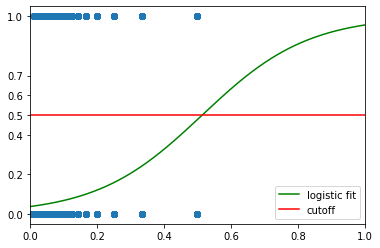

In [101]:
from scipy.special import expit
#sigmoid = expit(list(test_pd.label))
#plt.scatter(iris_data[:,0],iris_target, c=iris_target,label = "sepal length")
plt.scatter(list(test_pd_1000.implied_prob), test_pd_1000.label) 
# ravel to convert the 2-d array to a flat array
plt.plot(x_test1,sigmoid.ravel(),c="green", label = "logistic fit")
plt.yticks([0, 0.2, 0.4, 0.5, 0.6, 0.7, 1])
plt.axhline(.5, color="red", label="cutoff")
plt.xlim([0, 1])
plt.legend(loc="lower right")

In [102]:
# connector is called 'mysql-connector-python'
# Google it and what you want to do
import mysql.connector

mydb = mysql.connector.connect(
  host="mysql",
  user="ssbd",
  password="pass",
  database='analysis_db'
)

print(mydb)

In [103]:
# https://stackoverflow.com/questions/44893565/get-list-of-mysql-databases-with-python
cursor = mydb.cursor()
databases = ("show databases")
cursor.execute(databases)
for (databases) in cursor:
     print (databases[0])

information_schema
analysis_db
mysql
performance_schema
sys


In [104]:
#https://www.geeksforgeeks.org/how-to-show-all-tables-in-mysql-using-python/
mycursor = mydb.cursor()
mycursor.execute("Show tables;")
myresult = mycursor.fetchall()
 
for x in myresult:
    print(x)

In [105]:
#runners_wbsp.filter(runners_wbsp["runner_name"]=="14.Coisa Boa").show()

In [106]:
#Oversampling
df_class_0 = train_1000[train_1000['label'] == 0]
df_class_1 = train_1000[train_1000['label'] == 1]

In [107]:
df_class_1_over = df_class_1.sample(withReplacement=True,fraction=6.9)
train_over = df_class_0.union(df_class_1_over)

In [108]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel_over = lr.fit(train_over)

In [109]:
import numpy as np
modelcoefficients=np.array(lrModel_over.coefficients)

names=[x["name"] for x in sorted(train.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
   train.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], 
   key=lambda x: x["idx"])]


matchcoefs=np.column_stack((modelcoefficients,np.array(names)))

import pandas as pd

matchcoefsdf=pd.DataFrame(matchcoefs)

matchcoefsdf.columns=['Coefvalue', 'Feature']

print(matchcoefsdf)

               Coefvalue                      Feature
0  -0.016043941706274358  is_fast_horse_numclassVec_0
1     7.4096908294755295                 implied_prob


In [110]:
predictions_train = lrModel_over.transform(train_over)

y_true = predictions_train.select(['label']).collect()
y_pred = predictions_train.select(['prediction']).collect()

In [111]:
from sklearn import linear_model
from scipy.special import expit

x_test1 = np.linspace(0.0,1.0,num=288)
# predict dummy y_test data based on the logistic model
y_test = x_test1 * lrModel_over.coefficients[1] + x_test1 * lrModel_over.coefficients[0] + lrModel_over.interceptVector
#y_test = x_test * 4 + 2
    
sigmoid = expit(y_test)

In [114]:
test_pd= test.toPandas()

KeyboardInterrupt: 

In [ ]:
from scipy.special import expit
#sigmoid = expit(list(test_pd.label))
#plt.scatter(iris_data[:,0],iris_target, c=iris_target,label = "sepal length")
plt.scatter(list(test_pd.implied_prob), test_pd.label) 
# ravel to convert the 2-d array to a flat array
plt.plot(x_test1,sigmoid.ravel(),c="green", label = "logistic fit")
plt.yticks([0, 0.2, 0.4, 0.5, 0.6, 0.7, 1])
plt.axhline(.5, color="red", label="cutoff")
plt.xlim([0, 1])
plt.legend(loc="lower right")

In [ ]:
#df_class_1.count()

In [ ]:
print("Multinomial coefficients: " + str(lrModel_over.coefficientMatrix))

In [ ]:
print("Multinomial intercept: " + str(lrModel_over.intercept))

In [ ]:
trainingSummary_over = lrModel_over.summary
roc_over = trainingSummary_over.roc.toPandas()
plt.plot(roc_over['FPR'],roc_over['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set area Under ROC: ' + str(trainingSummary_over.areaUnderROC))

In [ ]:
pr_over = trainingSummary_over.pr.toPandas()
plt.plot(pr_over['recall'],pr_over['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()